# Deep Learning: Endoscopy segmentation.
[Dataset](https://www.kaggle.com/datasets/newslab/cholecseg8k?resource=download)

In [1]:
import os

os.environ["CUBLAS_WORKSPACE_CONFIG"]=":4096:8"

In [2]:
import torch
from glob import glob
import numpy as np
import time
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
import cv2
import random
from pytorch_Uformer import modelPool
from pytorch_Uformer import losses
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [3]:
torch.cuda.is_available(), torch.cuda.get_device_name(0)

(True, 'NVIDIA GeForce RTX 2060 SUPER')

In [4]:
SEED = 33
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.use_deterministic_algorithms(True)

In [5]:
# determine the device to be used for training and evaluation
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
# determine if we will be pinning memory during data loading
PIN_MEMORY = True if DEVICE == "cuda" else False

NUM_CLASSES = 13
# initialize learning rate, number of epochs to train for, and the
# batch size
INIT_LR = 0.0001
NUM_EPOCHS = 100
BATCH_SIZE = 32
# define the input image dimensions
INPUT_IMAGE_WIDTH = 64
INPUT_IMAGE_HEIGHT = 64

## Data preparation.

In [6]:
IMAGE_DATASET_PATH = glob(f'../*/*/*/frame_*_endo.png')
MASK_DATASET_PATH  = glob(f'../*/*/*/frame_*_endo_watershed_mask.png')
N = len(IMAGE_DATASET_PATH)
assert len(IMAGE_DATASET_PATH) == len(MASK_DATASET_PATH)

print(f'Number of samples: {str(len(MASK_DATASET_PATH))}')

Number of samples: 8080


In [7]:
def to_categorical(y, num_classes=None, dtype="float32"):
	y = np.array(y, dtype="int")
	input_shape = y.shape

	# Shrink the last dimension if the shape is (..., 1).
	if input_shape and input_shape[-1] == 1 and len(input_shape) > 1:
		input_shape = tuple(input_shape[:-1])

	y = y.reshape(-1)
	if not num_classes:
		num_classes = np.max(y) + 1
	n = y.shape[0]
	categorical = np.zeros((n, num_classes), dtype=dtype)
	categorical[np.arange(n), y] = 1
	output_shape = input_shape + (num_classes,)
	categorical = np.reshape(categorical, output_shape)
	return categorical

labels = [[11],[21],[13],[12],[31],[23],[24],[25],[32],[22],[33],[5]]
def encode_mask(masks_arr, n_classes=NUM_CLASSES, H=INPUT_IMAGE_HEIGHT, W=INPUT_IMAGE_WIDTH, labels_arr=labels):
    y_encoded = np.zeros((H, W, 1), dtype=np.uint8)

    for i, label in enumerate(labels_arr):
        y_encoded[np.all(label == masks_arr, axis=-1)] = i + 1
    
    return to_categorical(y_encoded, num_classes=n_classes)

class SegmentationDataset(Dataset):
	def __init__(self, imagePaths, maskPaths):
		# store the image and mask filepaths, and augmentation
		# transforms
		self.imagePaths = imagePaths
		self.maskPaths = maskPaths

	def __len__(self):
		# return the number of total samples contained in the dataset
		return len(self.imagePaths)
	
	def __getitem__(self, idx):
		# grab the image path from the current index
		imagePath = self.imagePaths[idx]
		# load the image from disk, swap its channels from BGR to RGB,
		# and read the associated mask from disk in grayscale mode
		image = cv2.imread(imagePath)
		image = image[10:-10, 10:-10,:]
		image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
		image = cv2.resize(image, (INPUT_IMAGE_WIDTH, INPUT_IMAGE_HEIGHT))
		image = image / 255
		image = torch.from_numpy(np.float32(image))
		image = image.permute(2,0,1)

		mask = cv2.imread(self.maskPaths[idx])
		mask = mask[10:-10, 10:-10,:]
		mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
		mask = cv2.resize(mask, (INPUT_IMAGE_WIDTH, INPUT_IMAGE_HEIGHT), interpolation=cv2.INTER_NEAREST)
		mask = np.expand_dims(mask, axis=-1)
		mask = encode_mask(mask)
		mask = torch.from_numpy(np.float32(mask))
		mask = mask.permute(2,0,1)

		assert image.shape == (3, INPUT_IMAGE_HEIGHT, INPUT_IMAGE_WIDTH), f"Bad image shape {image.shape}"
		assert mask.shape == (13, INPUT_IMAGE_HEIGHT, INPUT_IMAGE_WIDTH), f"Bad mask shape {mask.shape}"

		# return a tuple of the image and its mask
		return image, mask

In [8]:
uformer = modelPool.Uformer(img_size=INPUT_IMAGE_HEIGHT,in_chans=13, embed_dim=16, win_size=8, token_projection='linear', token_mlp='leff',modulator=True)
trainImages, testImages, trainMasks, testMasks = train_test_split(IMAGE_DATASET_PATH, MASK_DATASET_PATH, test_size=0.2, random_state=43)

In [9]:
# define transformations
from torch.utils.data import DataLoader

# create the train and test datasets
trainDS = SegmentationDataset(imagePaths=trainImages, maskPaths=trainMasks)
testDS = SegmentationDataset(imagePaths=testImages, maskPaths=testMasks)
print(f"[INFO] found {len(trainDS)} examples in the training set...")
print(f"[INFO] found {len(testDS)} examples in the test set...")
# create the training and test data loaders
num_workers = 4
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(0)

trainLoader = DataLoader(
	trainDS, 
	shuffle=True,
	batch_size=BATCH_SIZE, 
	pin_memory=PIN_MEMORY,
    worker_init_fn=seed_worker,
    generator=g
)
testLoader = DataLoader(
	testDS, shuffle=False,
	batch_size=BATCH_SIZE, 
	pin_memory=PIN_MEMORY,
    worker_init_fn=seed_worker,
    generator=g
)

[INFO] found 6464 examples in the training set...
[INFO] found 1616 examples in the test set...


In [10]:
uformer = uformer.to(DEVICE)
softmax = torch.nn.Softmax(1)
# initialize loss function and optimizer
lossFunc = losses.TverskyLoss().cuda()
opt = torch.optim.Adam(uformer.parameters(), lr=INIT_LR, betas=(0.9, 0.999),eps=1e-8, weight_decay=1e-5)
iouMetric = losses.MeanIoU().cuda()
gdlMetric = losses.DiceCoeficient().cuda()
# calculate steps per epoch for training and test set
trainSteps = len(trainDS) // BATCH_SIZE
testSteps = len(testDS) // BATCH_SIZE
# initialize a dictionary to store training history
H = {"train_loss": [], "test_loss": [], "train_IoU": [], "test_IoU": [],"train_DC": [], "test_DC": []}

In [11]:
# loop over epochs
print("[INFO] training the network...")
startTime = time.time()
for e in range(NUM_EPOCHS):
	torch.cuda.empty_cache()
	# set the model in training mode
	uformer.train()
	# initialize the total training and validation loss
	totalTrainLoss = 0
	totalTestLoss = 0

	totalTrainIoU = 0
	totalTestIoU = 0
	totalTrainDC = 0
	totalTestDC = 0
	# loop over the training set
	for i, (x, y) in enumerate(tqdm(trainLoader)):
		# send the input to the device
		x, y = x.to(DEVICE), y.to(DEVICE)
		# perform a forward pass and calculate the training loss
		pred = uformer(x)
		assert pred.shape == y.shape, f"{pred.shape} != {y.shape}" # B, C, H, W
		pred = softmax(pred)
		loss = lossFunc(pred, y)
		# first, zero out any previously accumulated gradients, then
		# perform backpropagation, and then update model parameters
		opt.zero_grad()
		loss.backward()
		opt.step()
		# add the loss to the total training loss so far
		totalTrainLoss += loss
		totalTrainIoU += iouMetric(pred, y)
		totalTrainDC += gdlMetric(pred, y)
	# switch off autograd
	with torch.no_grad():
		# set the model in evaluation mode
		uformer.eval()
		# loop over the validation set
		for (x, y) in testLoader:
			# send the input to the device
			(x, y) = (x.to(DEVICE), y.to(DEVICE))
			# make the predictions and calculate the validation loss
			pred = uformer(x)
			assert pred.shape == y.shape, f"{pred.shape} != {y.shape}" # B, C, H, W
			pred = softmax(pred)
			totalTestLoss += lossFunc(pred, y)
			totalTestIoU += iouMetric(pred, y)
			totalTestDC += gdlMetric(pred, y)
			
	# calculate the average training and validation loss
	avgTrainLoss = totalTrainLoss / trainSteps
	avgTestLoss = totalTestLoss / testSteps

	avgTrainIoU = totalTrainIoU / trainSteps
	avgTestIoU = totalTestIoU / testSteps
	avgTrainDC = totalTrainDC / trainSteps
	avgTestDC = totalTestDC / testSteps
	# update our training history
	H["train_loss"].append(avgTrainLoss.cpu().detach().numpy())
	H["test_loss"].append(avgTestLoss.cpu().detach().numpy())

	H["train_IoU"].append(avgTrainIoU.cpu().detach().numpy())
	H["test_IoU"].append(avgTestIoU.cpu().detach().numpy())
	H["train_DC"].append(avgTrainDC.cpu().detach().numpy())
	H["test_DC"].append(avgTestDC.cpu().detach().numpy())

	# print the model training and validation information
	print("[INFO] EPOCH: {}/{}".format(e + 1, NUM_EPOCHS))
	print(f"Train loss: {avgTrainLoss:.6f}, Test loss: {avgTestLoss:.4f}, " + 
       f"Train IoU: {avgTrainIoU:.4f}, Test IoU: {avgTestIoU:.4f}, Train Dice: {avgTrainDC:.4f}, Test Dice: {avgTestDC:.4f}")

# display the total time needed to perform the training
endTime = time.time()
print("[INFO] total time taken to train the model: {:.2f}s".format(endTime - startTime))

[INFO] training the network...


100%|██████████| 202/202 [01:49<00:00,  1.85it/s]


[INFO] EPOCH: 1/100
Train loss: 0.445017, Test loss: 0.2866, Train IoU: 0.3995, Test IoU: 0.5733, Train Dice: 0.5550, Test Dice: 0.7334


100%|██████████| 202/202 [01:49<00:00,  1.84it/s]


[INFO] EPOCH: 2/100
Train loss: 0.237341, Test loss: 0.2017, Train IoU: 0.6178, Test IoU: 0.6836, Train Dice: 0.7627, Test Dice: 0.8183


100%|██████████| 202/202 [01:49<00:00,  1.85it/s]


[INFO] EPOCH: 3/100
Train loss: 0.193030, Test loss: 0.1789, Train IoU: 0.6771, Test IoU: 0.7160, Train Dice: 0.8070, Test Dice: 0.8411


100%|██████████| 202/202 [01:54<00:00,  1.77it/s]


[INFO] EPOCH: 4/100
Train loss: 0.175577, Test loss: 0.1671, Train IoU: 0.7019, Test IoU: 0.7332, Train Dice: 0.8244, Test Dice: 0.8529


100%|██████████| 202/202 [01:48<00:00,  1.86it/s]


[INFO] EPOCH: 5/100
Train loss: 0.165849, Test loss: 0.1625, Train IoU: 0.7161, Test IoU: 0.7400, Train Dice: 0.8342, Test Dice: 0.8575


100%|██████████| 202/202 [01:48<00:00,  1.86it/s]


[INFO] EPOCH: 6/100
Train loss: 0.157764, Test loss: 0.1496, Train IoU: 0.7280, Test IoU: 0.7595, Train Dice: 0.8422, Test Dice: 0.8704


100%|██████████| 202/202 [01:48<00:00,  1.86it/s]


[INFO] EPOCH: 7/100
Train loss: 0.146722, Test loss: 0.1411, Train IoU: 0.7446, Test IoU: 0.7725, Train Dice: 0.8533, Test Dice: 0.8789


100%|██████████| 202/202 [01:50<00:00,  1.83it/s]


[INFO] EPOCH: 8/100
Train loss: 0.140579, Test loss: 0.1355, Train IoU: 0.7540, Test IoU: 0.7812, Train Dice: 0.8594, Test Dice: 0.8845


100%|██████████| 202/202 [01:50<00:00,  1.83it/s]


[INFO] EPOCH: 9/100
Train loss: 0.136877, Test loss: 0.1323, Train IoU: 0.7597, Test IoU: 0.7862, Train Dice: 0.8631, Test Dice: 0.8877


100%|██████████| 202/202 [01:52<00:00,  1.80it/s]


[INFO] EPOCH: 10/100
Train loss: 0.132268, Test loss: 0.1309, Train IoU: 0.7669, Test IoU: 0.7884, Train Dice: 0.8677, Test Dice: 0.8891


100%|██████████| 202/202 [01:52<00:00,  1.79it/s]


[INFO] EPOCH: 11/100
Train loss: 0.128741, Test loss: 0.1254, Train IoU: 0.7723, Test IoU: 0.7971, Train Dice: 0.8713, Test Dice: 0.8946


100%|██████████| 202/202 [01:51<00:00,  1.82it/s]


[INFO] EPOCH: 12/100
Train loss: 0.125194, Test loss: 0.1206, Train IoU: 0.7779, Test IoU: 0.8047, Train Dice: 0.8748, Test Dice: 0.8994


100%|██████████| 202/202 [01:51<00:00,  1.82it/s]


[INFO] EPOCH: 13/100
Train loss: 0.122337, Test loss: 0.1181, Train IoU: 0.7824, Test IoU: 0.8088, Train Dice: 0.8777, Test Dice: 0.9019


100%|██████████| 202/202 [01:51<00:00,  1.81it/s]


[INFO] EPOCH: 14/100
Train loss: 0.119393, Test loss: 0.1152, Train IoU: 0.7871, Test IoU: 0.8134, Train Dice: 0.8806, Test Dice: 0.9048


100%|██████████| 202/202 [01:51<00:00,  1.80it/s]


[INFO] EPOCH: 15/100
Train loss: 0.116806, Test loss: 0.1149, Train IoU: 0.7913, Test IoU: 0.8139, Train Dice: 0.8832, Test Dice: 0.9051


100%|██████████| 202/202 [01:53<00:00,  1.79it/s]


[INFO] EPOCH: 16/100
Train loss: 0.113776, Test loss: 0.1108, Train IoU: 0.7961, Test IoU: 0.8206, Train Dice: 0.8862, Test Dice: 0.9092


100%|██████████| 202/202 [01:51<00:00,  1.82it/s]


[INFO] EPOCH: 17/100
Train loss: 0.112656, Test loss: 0.1098, Train IoU: 0.7979, Test IoU: 0.8222, Train Dice: 0.8873, Test Dice: 0.9102


100%|██████████| 202/202 [01:51<00:00,  1.81it/s]


[INFO] EPOCH: 18/100
Train loss: 0.109879, Test loss: 0.1070, Train IoU: 0.8025, Test IoU: 0.8267, Train Dice: 0.8901, Test Dice: 0.9130


100%|██████████| 202/202 [01:51<00:00,  1.81it/s]


[INFO] EPOCH: 19/100
Train loss: 0.107907, Test loss: 0.1059, Train IoU: 0.8056, Test IoU: 0.8285, Train Dice: 0.8921, Test Dice: 0.9141


100%|██████████| 202/202 [01:50<00:00,  1.82it/s]


[INFO] EPOCH: 20/100
Train loss: 0.105754, Test loss: 0.1024, Train IoU: 0.8091, Test IoU: 0.8343, Train Dice: 0.8942, Test Dice: 0.9176


100%|██████████| 202/202 [01:50<00:00,  1.83it/s]


[INFO] EPOCH: 21/100
Train loss: 0.103891, Test loss: 0.1020, Train IoU: 0.8122, Test IoU: 0.8350, Train Dice: 0.8961, Test Dice: 0.9180


100%|██████████| 202/202 [01:51<00:00,  1.81it/s]


[INFO] EPOCH: 22/100
Train loss: 0.102147, Test loss: 0.1001, Train IoU: 0.8151, Test IoU: 0.8381, Train Dice: 0.8979, Test Dice: 0.9199


100%|██████████| 202/202 [01:53<00:00,  1.78it/s]


[INFO] EPOCH: 23/100
Train loss: 0.096976, Test loss: 0.0877, Train IoU: 0.8236, Test IoU: 0.8587, Train Dice: 0.9030, Test Dice: 0.9323


100%|██████████| 202/202 [01:51<00:00,  1.82it/s]


[INFO] EPOCH: 24/100
Train loss: 0.088735, Test loss: 0.0858, Train IoU: 0.8373, Test IoU: 0.8620, Train Dice: 0.9113, Test Dice: 0.9342


100%|██████████| 202/202 [01:49<00:00,  1.84it/s]


[INFO] EPOCH: 25/100
Train loss: 0.085454, Test loss: 0.0804, Train IoU: 0.8428, Test IoU: 0.8711, Train Dice: 0.9145, Test Dice: 0.9396


100%|██████████| 202/202 [01:52<00:00,  1.79it/s]


[INFO] EPOCH: 26/100
Train loss: 0.084357, Test loss: 0.0807, Train IoU: 0.8447, Test IoU: 0.8707, Train Dice: 0.9156, Test Dice: 0.9393


100%|██████████| 202/202 [01:52<00:00,  1.80it/s]


[INFO] EPOCH: 27/100
Train loss: 0.081057, Test loss: 0.0776, Train IoU: 0.8503, Test IoU: 0.8759, Train Dice: 0.9189, Test Dice: 0.9424


100%|██████████| 202/202 [01:52<00:00,  1.79it/s]


[INFO] EPOCH: 28/100
Train loss: 0.079621, Test loss: 0.0761, Train IoU: 0.8527, Test IoU: 0.8786, Train Dice: 0.9204, Test Dice: 0.9439


100%|██████████| 202/202 [01:51<00:00,  1.81it/s]


[INFO] EPOCH: 29/100
Train loss: 0.077835, Test loss: 0.0759, Train IoU: 0.8558, Test IoU: 0.8790, Train Dice: 0.9222, Test Dice: 0.9441


100%|██████████| 202/202 [01:51<00:00,  1.81it/s]


[INFO] EPOCH: 30/100
Train loss: 0.076821, Test loss: 0.0741, Train IoU: 0.8576, Test IoU: 0.8820, Train Dice: 0.9232, Test Dice: 0.9459


100%|██████████| 202/202 [01:51<00:00,  1.80it/s]


[INFO] EPOCH: 31/100
Train loss: 0.076095, Test loss: 0.0738, Train IoU: 0.8588, Test IoU: 0.8825, Train Dice: 0.9239, Test Dice: 0.9462


100%|██████████| 202/202 [01:49<00:00,  1.84it/s]


[INFO] EPOCH: 32/100
Train loss: 0.075075, Test loss: 0.0724, Train IoU: 0.8606, Test IoU: 0.8849, Train Dice: 0.9249, Test Dice: 0.9476


100%|██████████| 202/202 [01:51<00:00,  1.81it/s]


[INFO] EPOCH: 33/100
Train loss: 0.074643, Test loss: 0.0725, Train IoU: 0.8613, Test IoU: 0.8847, Train Dice: 0.9254, Test Dice: 0.9475


100%|██████████| 202/202 [01:48<00:00,  1.85it/s]


[INFO] EPOCH: 34/100
Train loss: 0.073282, Test loss: 0.0712, Train IoU: 0.8637, Test IoU: 0.8871, Train Dice: 0.9267, Test Dice: 0.9488


100%|██████████| 202/202 [01:50<00:00,  1.83it/s]


[INFO] EPOCH: 35/100
Train loss: 0.072417, Test loss: 0.0698, Train IoU: 0.8652, Test IoU: 0.8896, Train Dice: 0.9276, Test Dice: 0.9502


100%|██████████| 202/202 [01:49<00:00,  1.84it/s]


[INFO] EPOCH: 36/100
Train loss: 0.071378, Test loss: 0.0694, Train IoU: 0.8670, Test IoU: 0.8902, Train Dice: 0.9286, Test Dice: 0.9506


100%|██████████| 202/202 [01:50<00:00,  1.83it/s]


[INFO] EPOCH: 37/100
Train loss: 0.070564, Test loss: 0.0678, Train IoU: 0.8684, Test IoU: 0.8931, Train Dice: 0.9294, Test Dice: 0.9522


100%|██████████| 202/202 [01:49<00:00,  1.84it/s]


[INFO] EPOCH: 38/100
Train loss: 0.070007, Test loss: 0.0681, Train IoU: 0.8694, Test IoU: 0.8925, Train Dice: 0.9300, Test Dice: 0.9519


100%|██████████| 202/202 [01:49<00:00,  1.84it/s]


[INFO] EPOCH: 39/100
Train loss: 0.069079, Test loss: 0.0681, Train IoU: 0.8710, Test IoU: 0.8924, Train Dice: 0.9309, Test Dice: 0.9519


100%|██████████| 202/202 [01:48<00:00,  1.87it/s]


[INFO] EPOCH: 40/100
Train loss: 0.068349, Test loss: 0.0658, Train IoU: 0.8723, Test IoU: 0.8966, Train Dice: 0.9317, Test Dice: 0.9542


100%|██████████| 202/202 [01:48<00:00,  1.86it/s]


[INFO] EPOCH: 41/100
Train loss: 0.067762, Test loss: 0.0654, Train IoU: 0.8733, Test IoU: 0.8972, Train Dice: 0.9322, Test Dice: 0.9546


100%|██████████| 202/202 [01:49<00:00,  1.85it/s]


[INFO] EPOCH: 42/100
Train loss: 0.066977, Test loss: 0.0657, Train IoU: 0.8747, Test IoU: 0.8967, Train Dice: 0.9330, Test Dice: 0.9543


100%|██████████| 202/202 [01:49<00:00,  1.85it/s]


[INFO] EPOCH: 43/100
Train loss: 0.066214, Test loss: 0.0642, Train IoU: 0.8760, Test IoU: 0.8994, Train Dice: 0.9338, Test Dice: 0.9558


100%|██████████| 202/202 [01:49<00:00,  1.85it/s]


[INFO] EPOCH: 44/100
Train loss: 0.065344, Test loss: 0.0639, Train IoU: 0.8775, Test IoU: 0.8998, Train Dice: 0.9347, Test Dice: 0.9561


100%|██████████| 202/202 [01:49<00:00,  1.85it/s]


[INFO] EPOCH: 45/100
Train loss: 0.065056, Test loss: 0.0633, Train IoU: 0.8780, Test IoU: 0.9009, Train Dice: 0.9349, Test Dice: 0.9567


100%|██████████| 202/202 [01:49<00:00,  1.84it/s]


[INFO] EPOCH: 46/100
Train loss: 0.064582, Test loss: 0.0625, Train IoU: 0.8789, Test IoU: 0.9024, Train Dice: 0.9354, Test Dice: 0.9575


100%|██████████| 202/202 [01:48<00:00,  1.86it/s]


[INFO] EPOCH: 47/100
Train loss: 0.064100, Test loss: 0.0625, Train IoU: 0.8798, Test IoU: 0.9024, Train Dice: 0.9359, Test Dice: 0.9575


100%|██████████| 202/202 [01:48<00:00,  1.86it/s]


[INFO] EPOCH: 48/100
Train loss: 0.063609, Test loss: 0.0620, Train IoU: 0.8806, Test IoU: 0.9032, Train Dice: 0.9364, Test Dice: 0.9580


100%|██████████| 202/202 [01:49<00:00,  1.85it/s]


[INFO] EPOCH: 49/100
Train loss: 0.063317, Test loss: 0.0611, Train IoU: 0.8811, Test IoU: 0.9047, Train Dice: 0.9367, Test Dice: 0.9589


100%|██████████| 202/202 [01:48<00:00,  1.85it/s]


[INFO] EPOCH: 50/100
Train loss: 0.063002, Test loss: 0.0609, Train IoU: 0.8817, Test IoU: 0.9052, Train Dice: 0.9370, Test Dice: 0.9591


100%|██████████| 202/202 [01:49<00:00,  1.84it/s]


[INFO] EPOCH: 51/100
Train loss: 0.061921, Test loss: 0.0604, Train IoU: 0.8836, Test IoU: 0.9060, Train Dice: 0.9381, Test Dice: 0.9596


100%|██████████| 202/202 [01:51<00:00,  1.80it/s]


[INFO] EPOCH: 52/100
Train loss: 0.061427, Test loss: 0.0598, Train IoU: 0.8845, Test IoU: 0.9072, Train Dice: 0.9386, Test Dice: 0.9602


100%|██████████| 202/202 [01:51<00:00,  1.82it/s]


[INFO] EPOCH: 53/100
Train loss: 0.061161, Test loss: 0.0590, Train IoU: 0.8849, Test IoU: 0.9085, Train Dice: 0.9388, Test Dice: 0.9610


100%|██████████| 202/202 [01:49<00:00,  1.84it/s]


[INFO] EPOCH: 54/100
Train loss: 0.059738, Test loss: 0.0578, Train IoU: 0.8874, Test IoU: 0.9107, Train Dice: 0.9403, Test Dice: 0.9622


100%|██████████| 202/202 [01:48<00:00,  1.87it/s]


[INFO] EPOCH: 55/100
Train loss: 0.058949, Test loss: 0.0572, Train IoU: 0.8888, Test IoU: 0.9119, Train Dice: 0.9411, Test Dice: 0.9628


100%|██████████| 202/202 [02:30<00:00,  1.34it/s]


[INFO] EPOCH: 56/100
Train loss: 0.058426, Test loss: 0.0563, Train IoU: 0.8898, Test IoU: 0.9134, Train Dice: 0.9416, Test Dice: 0.9637


100%|██████████| 202/202 [02:25<00:00,  1.39it/s]


[INFO] EPOCH: 57/100
Train loss: 0.058071, Test loss: 0.0568, Train IoU: 0.8904, Test IoU: 0.9125, Train Dice: 0.9419, Test Dice: 0.9632


100%|██████████| 202/202 [01:51<00:00,  1.81it/s]


[INFO] EPOCH: 58/100
Train loss: 0.057719, Test loss: 0.0563, Train IoU: 0.8910, Test IoU: 0.9134, Train Dice: 0.9423, Test Dice: 0.9637


100%|██████████| 202/202 [01:51<00:00,  1.82it/s]


[INFO] EPOCH: 59/100
Train loss: 0.057206, Test loss: 0.0559, Train IoU: 0.8920, Test IoU: 0.9141, Train Dice: 0.9428, Test Dice: 0.9641


100%|██████████| 202/202 [01:50<00:00,  1.83it/s]


[INFO] EPOCH: 60/100
Train loss: 0.057222, Test loss: 0.0554, Train IoU: 0.8920, Test IoU: 0.9150, Train Dice: 0.9428, Test Dice: 0.9646


100%|██████████| 202/202 [01:48<00:00,  1.87it/s]


[INFO] EPOCH: 61/100
Train loss: 0.056800, Test loss: 0.0555, Train IoU: 0.8927, Test IoU: 0.9149, Train Dice: 0.9432, Test Dice: 0.9645


100%|██████████| 202/202 [01:48<00:00,  1.87it/s]


[INFO] EPOCH: 62/100
Train loss: 0.056642, Test loss: 0.0552, Train IoU: 0.8930, Test IoU: 0.9154, Train Dice: 0.9434, Test Dice: 0.9648


100%|██████████| 202/202 [01:48<00:00,  1.86it/s]


[INFO] EPOCH: 63/100
Train loss: 0.055786, Test loss: 0.0543, Train IoU: 0.8945, Test IoU: 0.9169, Train Dice: 0.9442, Test Dice: 0.9657


100%|██████████| 202/202 [01:48<00:00,  1.86it/s]


[INFO] EPOCH: 64/100
Train loss: 0.055365, Test loss: 0.0546, Train IoU: 0.8953, Test IoU: 0.9164, Train Dice: 0.9446, Test Dice: 0.9654


100%|██████████| 202/202 [01:49<00:00,  1.85it/s]


[INFO] EPOCH: 65/100
Train loss: 0.055202, Test loss: 0.0546, Train IoU: 0.8955, Test IoU: 0.9165, Train Dice: 0.9448, Test Dice: 0.9654


100%|██████████| 202/202 [01:48<00:00,  1.86it/s]


[INFO] EPOCH: 66/100
Train loss: 0.054817, Test loss: 0.0540, Train IoU: 0.8962, Test IoU: 0.9176, Train Dice: 0.9452, Test Dice: 0.9660


100%|██████████| 202/202 [01:48<00:00,  1.86it/s]


[INFO] EPOCH: 67/100
Train loss: 0.054472, Test loss: 0.0536, Train IoU: 0.8969, Test IoU: 0.9183, Train Dice: 0.9455, Test Dice: 0.9664


100%|██████████| 202/202 [01:49<00:00,  1.85it/s]


[INFO] EPOCH: 68/100
Train loss: 0.054462, Test loss: 0.0535, Train IoU: 0.8969, Test IoU: 0.9184, Train Dice: 0.9455, Test Dice: 0.9665


100%|██████████| 202/202 [01:49<00:00,  1.85it/s]


[INFO] EPOCH: 69/100
Train loss: 0.053980, Test loss: 0.0527, Train IoU: 0.8978, Test IoU: 0.9198, Train Dice: 0.9460, Test Dice: 0.9673


100%|██████████| 202/202 [01:50<00:00,  1.82it/s]


[INFO] EPOCH: 70/100
Train loss: 0.053672, Test loss: 0.0527, Train IoU: 0.8983, Test IoU: 0.9199, Train Dice: 0.9463, Test Dice: 0.9673


100%|██████████| 202/202 [01:50<00:00,  1.83it/s]


[INFO] EPOCH: 71/100
Train loss: 0.053107, Test loss: 0.0522, Train IoU: 0.8993, Test IoU: 0.9208, Train Dice: 0.9469, Test Dice: 0.9678


100%|██████████| 202/202 [01:51<00:00,  1.81it/s]


[INFO] EPOCH: 72/100
Train loss: 0.053404, Test loss: 0.0517, Train IoU: 0.8988, Test IoU: 0.9217, Train Dice: 0.9466, Test Dice: 0.9683


100%|██████████| 202/202 [01:49<00:00,  1.84it/s]


[INFO] EPOCH: 73/100
Train loss: 0.052669, Test loss: 0.0515, Train IoU: 0.9001, Test IoU: 0.9220, Train Dice: 0.9473, Test Dice: 0.9685


100%|██████████| 202/202 [01:49<00:00,  1.84it/s]


[INFO] EPOCH: 74/100
Train loss: 0.052611, Test loss: 0.0514, Train IoU: 0.9002, Test IoU: 0.9223, Train Dice: 0.9474, Test Dice: 0.9686


100%|██████████| 202/202 [01:50<00:00,  1.83it/s]


[INFO] EPOCH: 75/100
Train loss: 0.052052, Test loss: 0.0509, Train IoU: 0.9012, Test IoU: 0.9231, Train Dice: 0.9479, Test Dice: 0.9691


100%|██████████| 202/202 [01:48<00:00,  1.86it/s]


[INFO] EPOCH: 76/100
Train loss: 0.051553, Test loss: 0.0508, Train IoU: 0.9021, Test IoU: 0.9233, Train Dice: 0.9484, Test Dice: 0.9692


100%|██████████| 202/202 [01:48<00:00,  1.87it/s]


[INFO] EPOCH: 77/100
Train loss: 0.051128, Test loss: 0.0505, Train IoU: 0.9029, Test IoU: 0.9239, Train Dice: 0.9489, Test Dice: 0.9695


100%|██████████| 202/202 [01:50<00:00,  1.83it/s]


[INFO] EPOCH: 78/100
Train loss: 0.051218, Test loss: 0.0505, Train IoU: 0.9027, Test IoU: 0.9239, Train Dice: 0.9488, Test Dice: 0.9695


100%|██████████| 202/202 [01:51<00:00,  1.81it/s]


[INFO] EPOCH: 79/100
Train loss: 0.050548, Test loss: 0.0499, Train IoU: 0.9040, Test IoU: 0.9250, Train Dice: 0.9495, Test Dice: 0.9701


100%|██████████| 202/202 [01:51<00:00,  1.81it/s]


[INFO] EPOCH: 80/100
Train loss: 0.050288, Test loss: 0.0504, Train IoU: 0.9044, Test IoU: 0.9241, Train Dice: 0.9497, Test Dice: 0.9696


100%|██████████| 202/202 [01:52<00:00,  1.80it/s]


[INFO] EPOCH: 81/100
Train loss: 0.050504, Test loss: 0.0498, Train IoU: 0.9040, Test IoU: 0.9251, Train Dice: 0.9495, Test Dice: 0.9702


100%|██████████| 202/202 [01:51<00:00,  1.81it/s]


[INFO] EPOCH: 82/100
Train loss: 0.049859, Test loss: 0.0494, Train IoU: 0.9052, Test IoU: 0.9259, Train Dice: 0.9501, Test Dice: 0.9706


100%|██████████| 202/202 [01:52<00:00,  1.79it/s]


[INFO] EPOCH: 83/100
Train loss: 0.050108, Test loss: 0.0485, Train IoU: 0.9048, Test IoU: 0.9275, Train Dice: 0.9499, Test Dice: 0.9715


100%|██████████| 202/202 [01:49<00:00,  1.85it/s]


[INFO] EPOCH: 84/100
Train loss: 0.044418, Test loss: 0.0422, Train IoU: 0.9151, Test IoU: 0.9391, Train Dice: 0.9556, Test Dice: 0.9778


100%|██████████| 202/202 [01:48<00:00,  1.87it/s]


[INFO] EPOCH: 85/100
Train loss: 0.040861, Test loss: 0.0394, Train IoU: 0.9216, Test IoU: 0.9443, Train Dice: 0.9591, Test Dice: 0.9806


100%|██████████| 202/202 [01:47<00:00,  1.87it/s]


[INFO] EPOCH: 86/100
Train loss: 0.039536, Test loss: 0.0389, Train IoU: 0.9241, Test IoU: 0.9451, Train Dice: 0.9605, Test Dice: 0.9811


100%|██████████| 202/202 [01:48<00:00,  1.86it/s]


[INFO] EPOCH: 87/100
Train loss: 0.038716, Test loss: 0.0379, Train IoU: 0.9256, Test IoU: 0.9470, Train Dice: 0.9613, Test Dice: 0.9821


100%|██████████| 202/202 [01:49<00:00,  1.84it/s]


[INFO] EPOCH: 88/100
Train loss: 0.038309, Test loss: 0.0374, Train IoU: 0.9264, Test IoU: 0.9479, Train Dice: 0.9617, Test Dice: 0.9826


100%|██████████| 202/202 [01:49<00:00,  1.85it/s]


[INFO] EPOCH: 89/100
Train loss: 0.037536, Test loss: 0.0371, Train IoU: 0.9278, Test IoU: 0.9485, Train Dice: 0.9625, Test Dice: 0.9829


100%|██████████| 202/202 [01:48<00:00,  1.86it/s]


[INFO] EPOCH: 90/100
Train loss: 0.037080, Test loss: 0.0372, Train IoU: 0.9287, Test IoU: 0.9484, Train Dice: 0.9629, Test Dice: 0.9828


100%|██████████| 202/202 [01:48<00:00,  1.86it/s]


[INFO] EPOCH: 91/100
Train loss: 0.036682, Test loss: 0.0363, Train IoU: 0.9294, Test IoU: 0.9499, Train Dice: 0.9633, Test Dice: 0.9837


100%|██████████| 202/202 [01:51<00:00,  1.80it/s]


[INFO] EPOCH: 92/100
Train loss: 0.036546, Test loss: 0.0362, Train IoU: 0.9297, Test IoU: 0.9502, Train Dice: 0.9635, Test Dice: 0.9838


100%|██████████| 202/202 [01:48<00:00,  1.86it/s]


[INFO] EPOCH: 93/100
Train loss: 0.036323, Test loss: 0.0357, Train IoU: 0.9301, Test IoU: 0.9511, Train Dice: 0.9637, Test Dice: 0.9843


100%|██████████| 202/202 [01:48<00:00,  1.86it/s]


[INFO] EPOCH: 94/100
Train loss: 0.036163, Test loss: 0.0357, Train IoU: 0.9304, Test IoU: 0.9510, Train Dice: 0.9638, Test Dice: 0.9843


100%|██████████| 202/202 [01:49<00:00,  1.84it/s]


[INFO] EPOCH: 95/100
Train loss: 0.035726, Test loss: 0.0357, Train IoU: 0.9312, Test IoU: 0.9511, Train Dice: 0.9643, Test Dice: 0.9843


100%|██████████| 202/202 [01:49<00:00,  1.84it/s]


[INFO] EPOCH: 96/100
Train loss: 0.035378, Test loss: 0.0353, Train IoU: 0.9318, Test IoU: 0.9519, Train Dice: 0.9646, Test Dice: 0.9847


100%|██████████| 202/202 [01:49<00:00,  1.85it/s]


[INFO] EPOCH: 97/100
Train loss: 0.035299, Test loss: 0.0349, Train IoU: 0.9320, Test IoU: 0.9526, Train Dice: 0.9647, Test Dice: 0.9851


100%|██████████| 202/202 [01:49<00:00,  1.84it/s]


[INFO] EPOCH: 98/100
Train loss: 0.035754, Test loss: 0.0357, Train IoU: 0.9311, Test IoU: 0.9512, Train Dice: 0.9642, Test Dice: 0.9843


100%|██████████| 202/202 [01:51<00:00,  1.81it/s]


[INFO] EPOCH: 99/100
Train loss: 0.035136, Test loss: 0.0348, Train IoU: 0.9323, Test IoU: 0.9527, Train Dice: 0.9649, Test Dice: 0.9852


100%|██████████| 202/202 [01:49<00:00,  1.85it/s]


[INFO] EPOCH: 100/100
Train loss: 0.034659, Test loss: 0.0348, Train IoU: 0.9332, Test IoU: 0.9527, Train Dice: 0.9653, Test Dice: 0.9852
[INFO] total time taken to train the model: 13169.53s


In [12]:
# serialize the model to disk
torch.save(uformer.state_dict(), '../models/uformerpool_tversky.pth')
# uformer.load_state_dict(torch.load('../models/uformer.pth'))

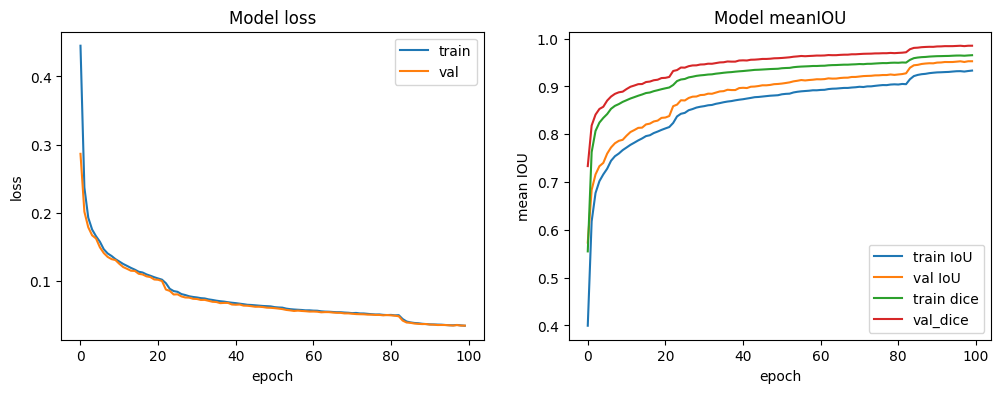

In [13]:
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(H['train_loss'])
plt.plot(H['test_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')

plt.subplot(122)
plt.plot(H['train_IoU'])
plt.plot(H['test_IoU'])
plt.plot(H['train_DC'])
plt.plot(H['test_DC'])
plt.title('Model meanIOU')
plt.ylabel('mean IOU')
plt.xlabel('epoch')

plt.legend(['train IoU', 'val IoU', 'train dice', 'val_dice'], loc='lower right')

plt.show()

In [14]:
def make_prediction(model, image):
	image = torch.Tensor(image).permute((2, 0, 1)).to(DEVICE)
	image = torch.unsqueeze(image, 0)
	# set model to evaluation mode
	model.eval()
	# turn off gradient tracking
	with torch.no_grad():
		predMask = model(image)
		predMask = softmax(predMask)
		predMask = torch.squeeze(predMask, 0)
		predMask = predMask.permute((1, 2, 0))
		predMask = predMask.cpu().detach().numpy()
		predMask = np.argmax(predMask, axis=-1)
		predMask = np.expand_dims(predMask, axis=-1)
		# filter out the weak predictions and convert them to integers
		return predMask.astype(np.uint8)


In [15]:
def getPredImg(image_path):     
    image = cv2.imread(image_path)
    image = image[10:-10, 10:-10,:]
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (INPUT_IMAGE_WIDTH, INPUT_IMAGE_HEIGHT))
    image = image / 255
    return image

def getPredMask(mask_path):
    mask = cv2.imread(mask_path)
    mask = mask[10:-10, 10:-10,:]
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    mask = cv2.resize(mask, (INPUT_IMAGE_WIDTH, INPUT_IMAGE_HEIGHT), interpolation=cv2.INTER_NEAREST)
    mask = np.expand_dims(mask, axis=-1)
    mask = encode_mask(mask)
    return mask

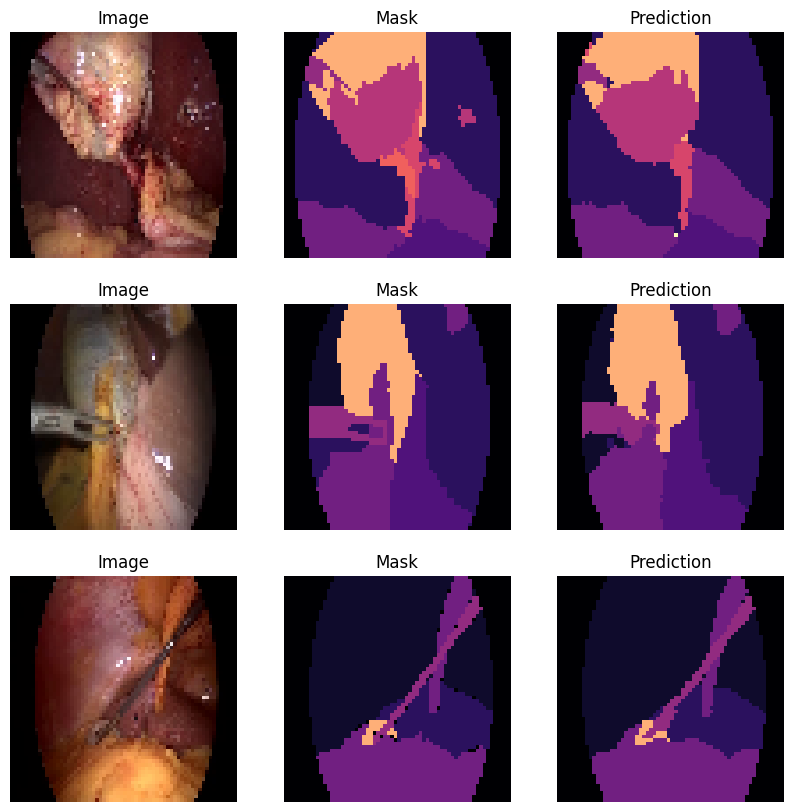

In [16]:
plt.figure(figsize=(10,10))
for i in range(3):    

    idx = random.randint(0, len(testImages) -1)
    img = getPredImg(testImages[idx])
    mask = getPredMask(testMasks[idx])
    
    plt.subplot(331 + 3*i)
    plt.imshow(img)
    plt.title('Image')
    plt.axis("off")

    mask = np.argmax(mask, axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    plt.subplot(332 + 3*i)
    plt.imshow(mask, cmap='magma', norm=plt.Normalize(vmin=0, vmax=12))
    plt.title('Mask')
    plt.axis("off")

    pred = make_prediction(uformer, img)
    plt.subplot(333 + 3*i)
    plt.imshow(pred, cmap='magma', norm=plt.Normalize(vmin=0, vmax=12))
    plt.title('Prediction')
    plt.axis("off")

plt.show()

 --- 
 TFG - Alejandro García Mota